# N2V Prediction
Please run the ```1_N2VTraining.ipynb``` before.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tifffile import imread

from ppn2v.pn2v.utils import PSNR
from ppn2v.pn2v import utils
from ppn2v.pn2v import prediction

# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

In [2]:
# We need the training data in order to calulate 'mean' and 'std' for normalization
path='../../../data/Convallaria_diaphragm/'

# Load the test data
dataTest=imread(path+"20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif")[:,:512,:512] 
# We are loading only a sub image to spped up computation

# We estimate the ground truth by averaging.
dataTestGT=np.mean(dataTest[:,...],axis=0)[np.newaxis,...]


### Load the Network and Noise Model
Ensure that ```dataName``` is set same as in ```1_N2VTraining.ipynb```.

In [3]:
dataName = 'convallaria' # Use the same name as used in 1_N2VTraining.ipynb. This is a part of model name created in N2VTraining.ipynb 
nameModel=dataName+'_n2v'

### Load the Network

In [4]:
# Load the network, created in the '01_N2VTraining.ipynb' notebook
net=torch.load(path+"/last_"+nameModel+".net")

### Evaluation

image: 0
PSNR input 29.009240856174337
PSNR prior 35.95447162323389
PSNR mse 35.95447162323389
-----------------------------------
image: 1
PSNR input 29.018589127299936
PSNR prior 35.90297876879336
PSNR mse 35.90297876879336
-----------------------------------
image: 2
PSNR input 29.035458856560645
PSNR prior 35.93462239987445
PSNR mse 35.93462239987445
-----------------------------------
image: 3
PSNR input 28.990347509982925
PSNR prior 35.938141105086686
PSNR mse 35.938141105086686
-----------------------------------
image: 4
PSNR input 29.002852113680238
PSNR prior 35.932926717671656
PSNR mse 35.932926717671656
-----------------------------------
image: 5
PSNR input 29.02402327393454
PSNR prior 35.935703038905594
PSNR mse 35.935703038905594
-----------------------------------
image: 6
PSNR input 29.032053580418268
PSNR prior 35.94423083781617
PSNR mse 35.94423083781617
-----------------------------------
image: 7
PSNR input 29.017435705343363
PSNR prior 35.95438183698903
PSNR mse 3

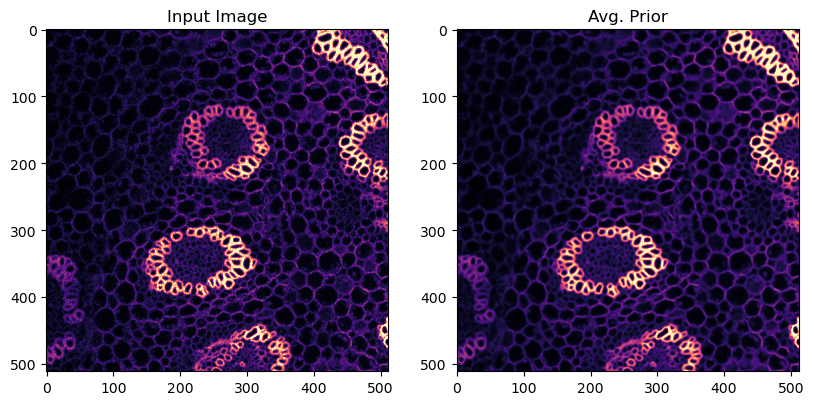

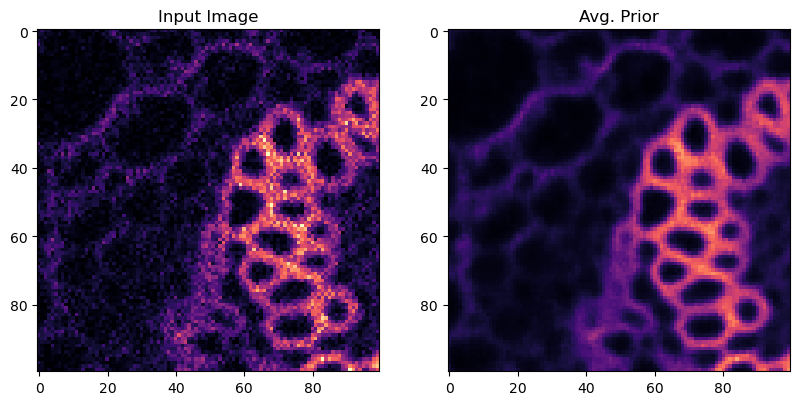

In [5]:
# Now we are processing data and calculating PSNR values.
results=[]
meanRes=[]
resultImgs=[]
inputImgs=[]

# We iterate over all test images.
for index in range(dataTest.shape[0]):
    
    im=dataTest[index]
    gt=dataTestGT[0] # The ground truth is the same for all images
    
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    
    means = prediction.tiledPredict(im, net ,ps=256, overlap=48,
                                            device=device, noiseModel=None)
    
    resultImgs.append(means)
    inputImgs.append(im)

    rangePSNR=np.max(gt)-np.min(gt)
    psnr=PSNR(gt, means,rangePSNR )
    psnrPrior=PSNR(gt, means,rangePSNR )
    results.append(psnr)
    meanRes.append(psnrPrior)

    print ("image:",index)
    print ("PSNR input",PSNR(gt, im, rangePSNR))
    print ("PSNR prior",psnrPrior) # Without info from masked pixel
    print ("PSNR mse",psnr) # MMSE estimate using the masked pixel
    print ('-----------------------------------')

    
    
    
# We display the results for the last test image       
vmi=np.percentile(gt,0.01)
vma=np.percentile(gt,99)

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title(label='Input Image')
plt.imshow(im, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 2)
plt.title(label='Avg. Prior')
plt.imshow(means, vmax=vma, vmin=vmi, cmap='magma')

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title(label='Input Image')
plt.imshow(im[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')
#plt.imsave('../../../imgs/raw_image.png', im[100:200,150:250])
plt.subplot(1, 3, 2)
plt.title(label='Avg. Prior')
plt.imshow(means[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')
#plt.imsave('../../../imgs/N2Vdenoised_image.png', im[100:200,150:250])

print("Avg PSNR Prior:", np.mean(np.array(meanRes) ), '+-(2SEM)',2*np.std(np.array(meanRes) )/np.sqrt(float(len(meanRes)) ) )
print("Avg PSNR MMSE:", np.mean(np.array(results) ),  '+-(2SEM)' ,2*np.std(np.array(results) )/np.sqrt(float(len(results)) ) )